#### Here we will evaluate the trained model

In [1]:
import os
import copy
import sys
import time
import math
from datetime import datetime
import time

import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from functools import reduce
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import ParameterGrid
import joblib

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler

from luca_utils import *

### check for GPU's
use_gpu = torch.cuda.is_available()

### Selecting experiment ( I just run 1)

In [2]:
## experiment dir 
exp_dir = 'C:/Users/gmpxe/Downloads/MIMIC_data_allbins.csv/Luca_experiment/'
data_dir = 'C:/Users/gmpxe/Downloads/MIMIC_data_allbins.csv/Luca_experiment/data/'
exp_name = 'lucspace'
exp_grid_run = 1

###################
# OPTIONAL:
continued = False
continued_grid = 0
orig_exp_name = exp_name
# load experiment
if continued == True:
    exp_name =  os.path.join(exp_name+"_"+str(continued_grid)+"_continued")
    print('CONTINUED experiment name: ', exp_name)
else:
    print('Experiment name: ', exp_name)
    
###################
### Load model config
model_config_file = 'models/lucspace_1_config.csv'
model_config_df = pd.read_csv(os.path.join(exp_dir, model_config_file), sep=',')
model_config = model_config_df.to_dict()


Experiment name:  lucspace


In [3]:
# set model location
exp_model = exp_dir+ 'models/' + exp_name + '_' + str(exp_grid_run) + '_model.chk'  
exp_resultsdir = os.path.join(exp_dir+ '/models/' + str(exp_name) + '_' + str(exp_grid_run) +'/')
exp_figuresdir = os.path.join(exp_dir + '/figures/')


In [4]:
# ASSIGN the CONFIG settings from the trained model
config = { 
          'state_dim' :   model_config['state_dim'][0],
          'action_dim' :  model_config['action_dim'][0],
          'gamma' :       model_config['gamma'][0],
          'hidden_dim' :  model_config['hidden_dim'][0],
          'num_hidden' :  model_config['num_hidden'][0],
          'drop_prob' :   model_config['drop_prob'][0],
          'option' :      model_config['option'][0],
          'num_epochs':   model_config['num_epochs'][0],
          'interim_step': model_config['tracking_step_interim_model'][0]
    
         }

In [5]:
config

{'state_dim': 47,
 'action_dim': 21,
 'gamma': 0.9,
 'hidden_dim': 128,
 'num_hidden': 2,
 'drop_prob': 0.0,
 'option': 'linear',
 'num_epochs': 350000,
 'interim_step': 5000}

In [6]:
# Define model structure to match the configuration from "best model" from 06_train_model.ipynb
model = dueling_net(D_in = config['state_dim'], 
                    H = config['hidden_dim'], 
                    D_out = config['action_dim'],
                    drop_prob = config['drop_prob'],
                    num_hidden = config['num_hidden'],
                    option = config['option'])

In [7]:
## Reading RL data 
data_dict = joblib.load(os.path.join(data_dir, 'Luca_data_dict.pkl'))

# Action probabilities of physician's action used for intermediate evaluateion
train_pi_behavior = pd.read_pickle(os.path.join(data_dir, 'KNN_pi_behavior_' + 'train' + 'data.pkl')) # pi_evaluation
val_pi_behavior = pd.read_pickle(os.path.join(data_dir, 'KNN_pi_behavior_' + 'val' + 'data.pkl')) # pi_evaluation
test_pi_behavior = pd.read_pickle(os.path.join(data_dir, 'KNN_pi_behavior_' + 'test' + 'data.pkl')) # pi_evaluation

# dataset MDP Q function (FQI-SARSA)
train_MDP_Q = pd.read_pickle(os.path.join(data_dir, 'FQI_QValues_' + 'train' + 'data.pkl'))
val_MDP_Q = pd.read_pickle(os.path.join(data_dir, 'FQI_QValues_' + 'val' + 'data.pkl'))
test_MDP_Q = pd.read_pickle(os.path.join(data_dir, 'FQI_QValues_' + 'test' + 'data.pkl'))



Experiment "lucspace" loaded with grid: 1
interim model:5000


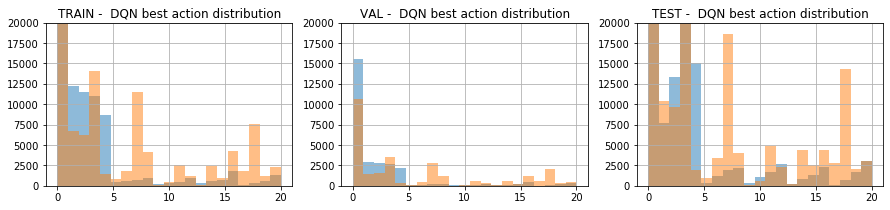

interim model:10000


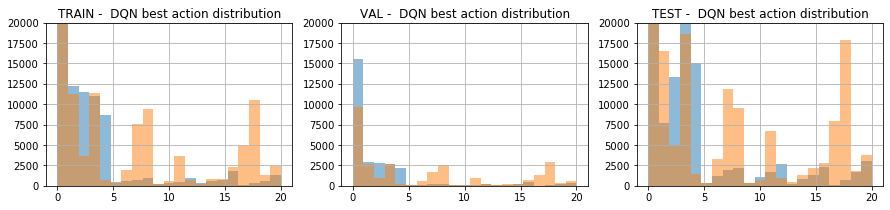

interim model:15000


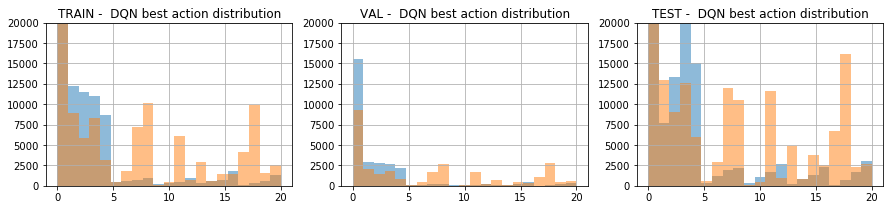

interim model:20000


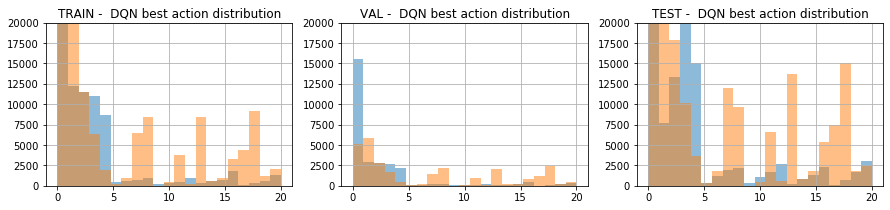

interim model:25000


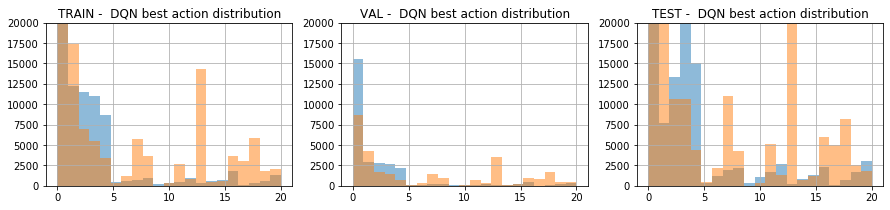

interim model:30000


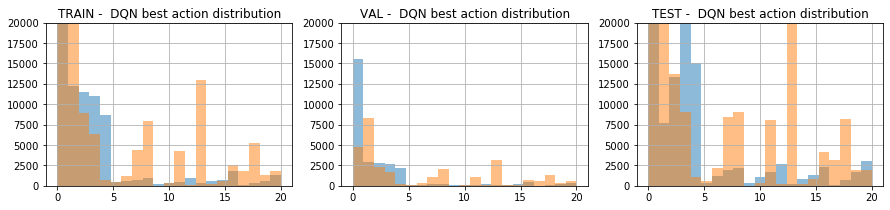

interim model:35000


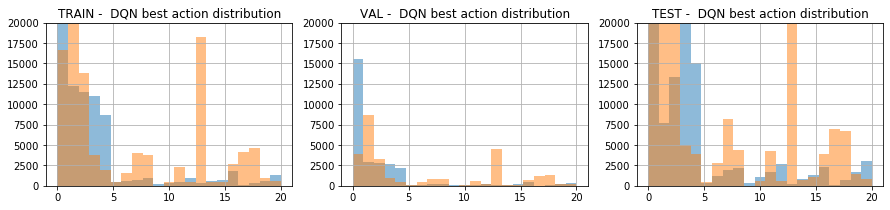

interim model:40000


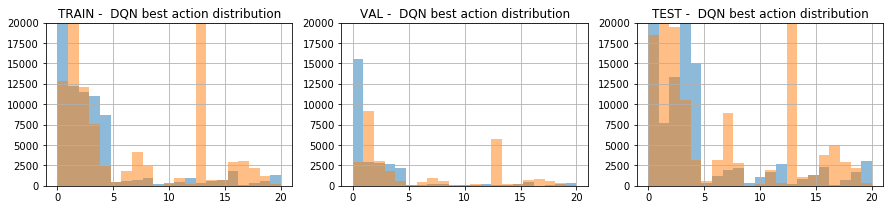

interim model:45000


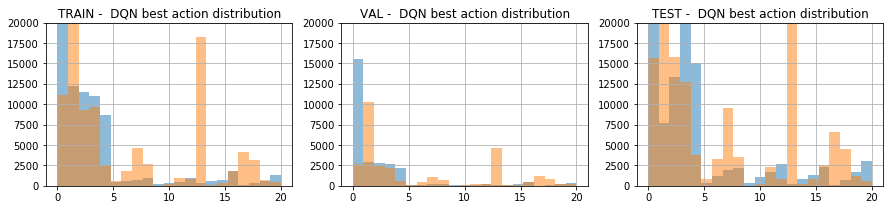

interim model:50000


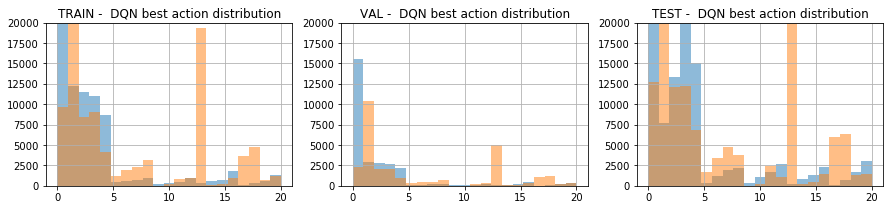

interim model:55000


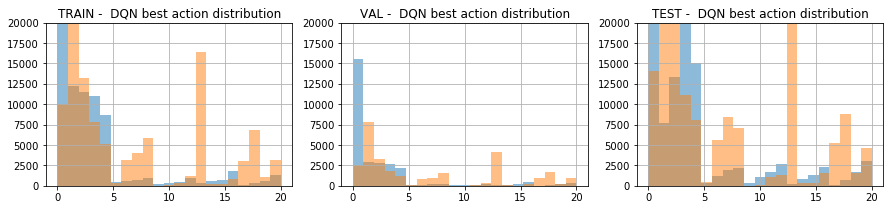

interim model:60000


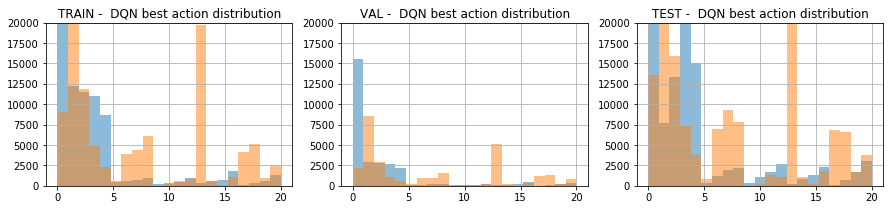

interim model:65000


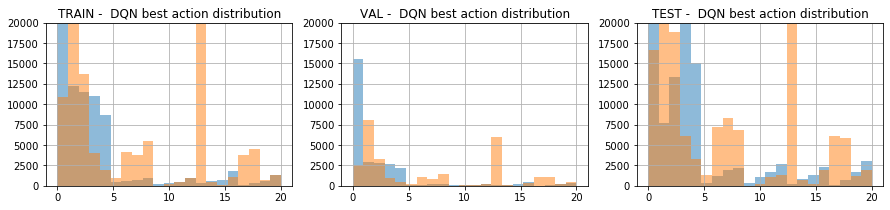

interim model:70000


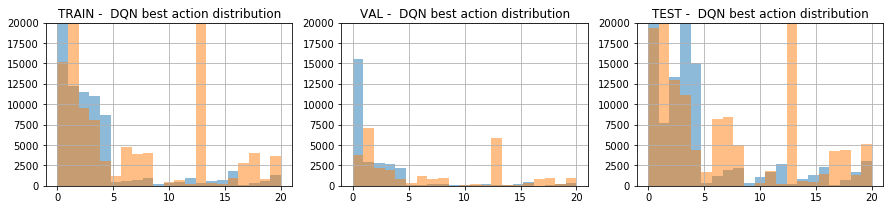

interim model:75000


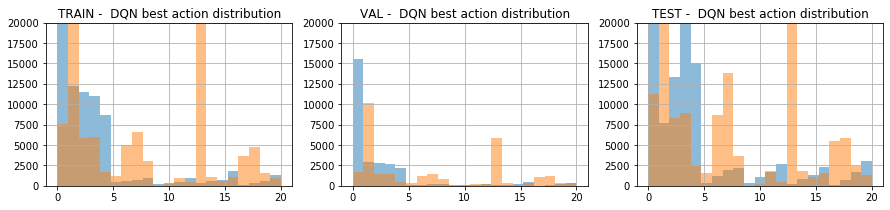

interim model:80000


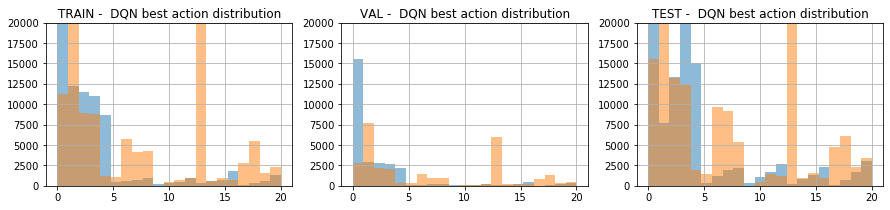

interim model:85000


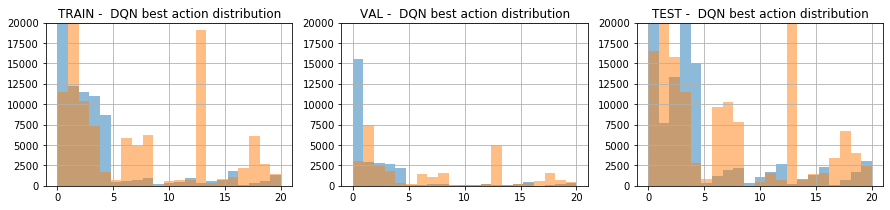

interim model:90000


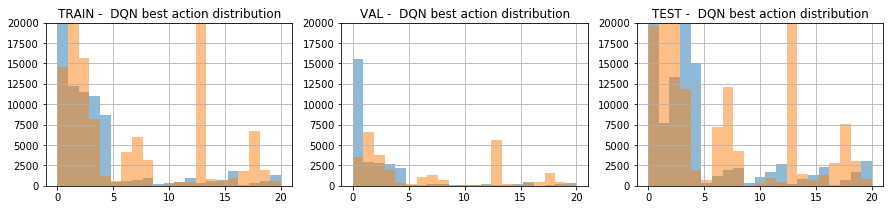

interim model:95000


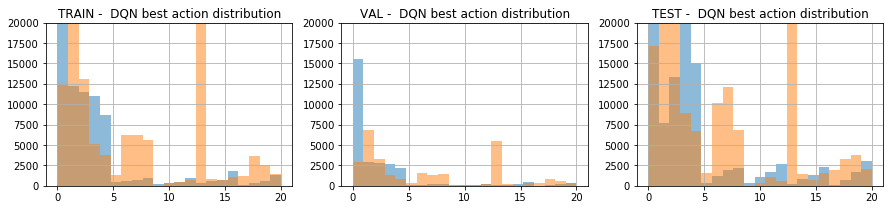

interim model:100000


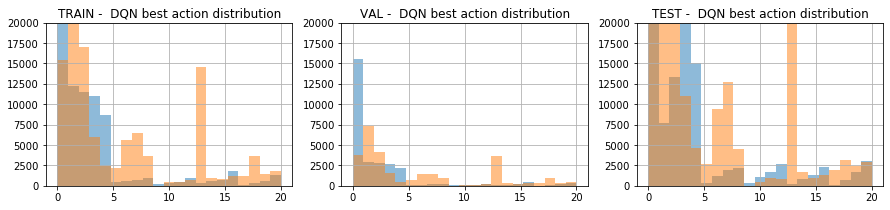

interim model:105000


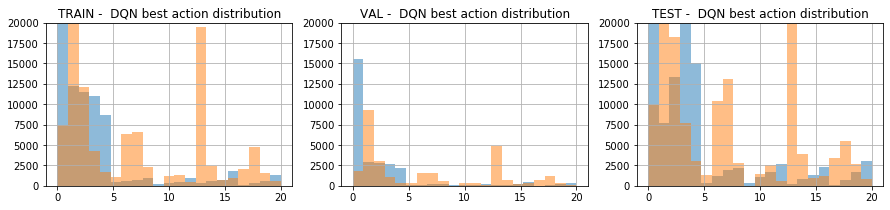

interim model:110000


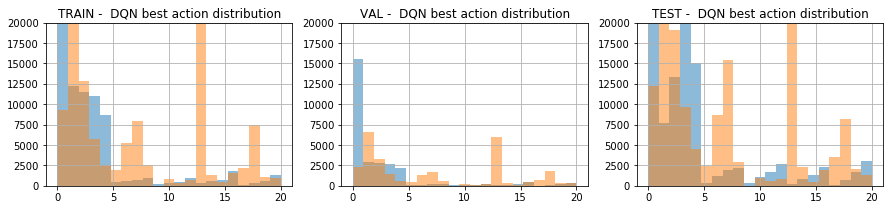

interim model:115000


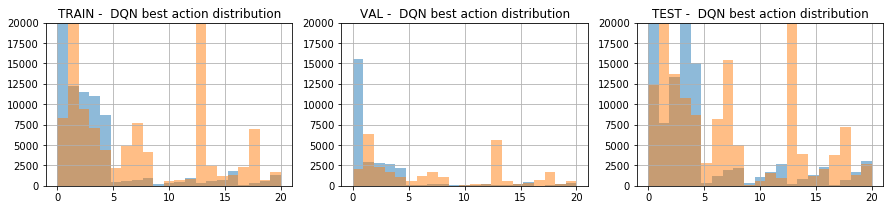

interim model:120000


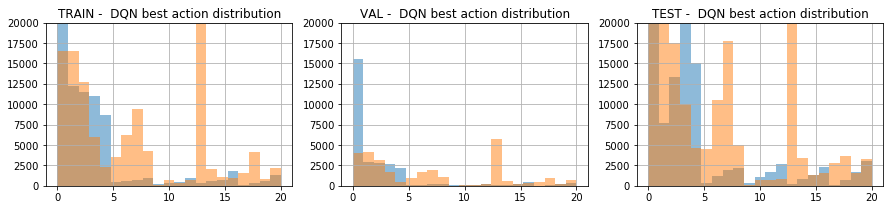

interim model:125000


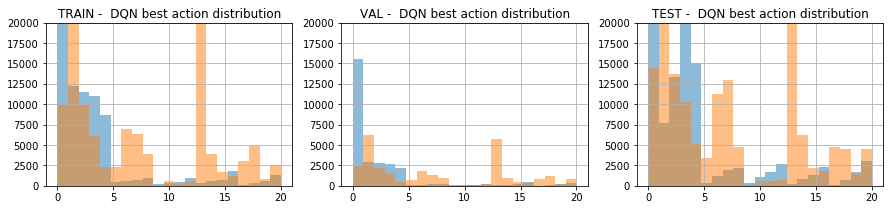

interim model:130000


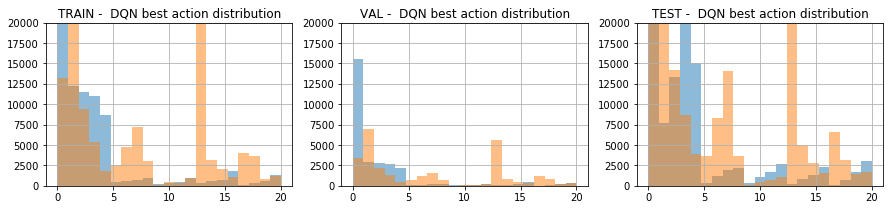

interim model:135000


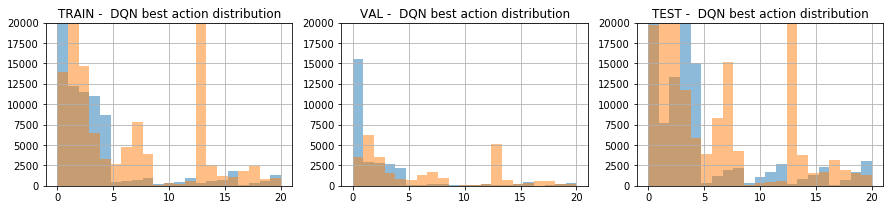

interim model:140000


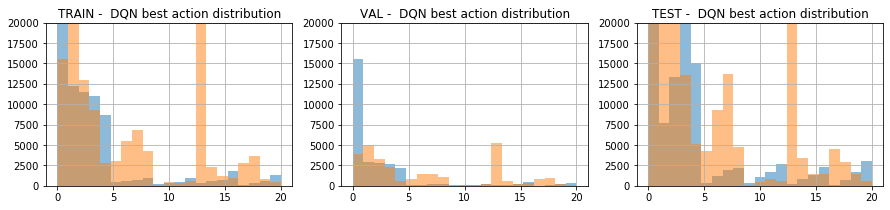

interim model:145000


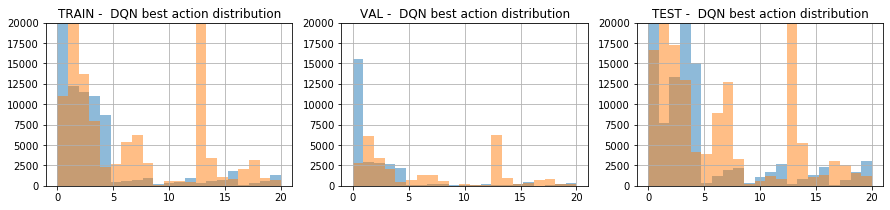

interim model:150000


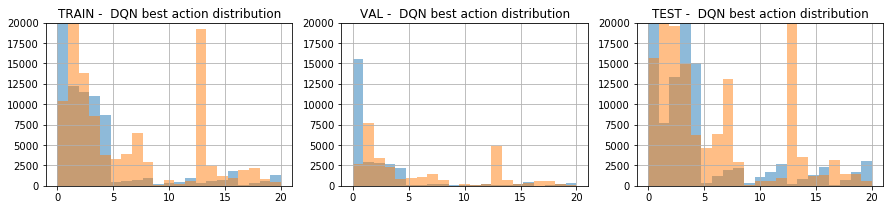

interim model:155000


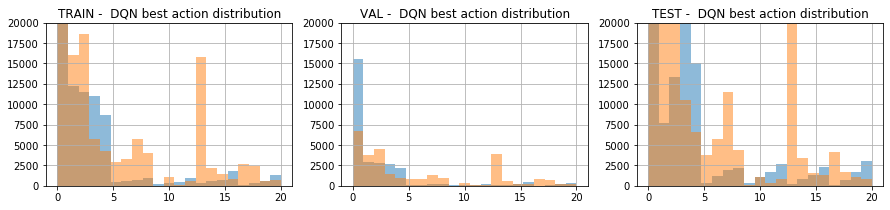

interim model:160000


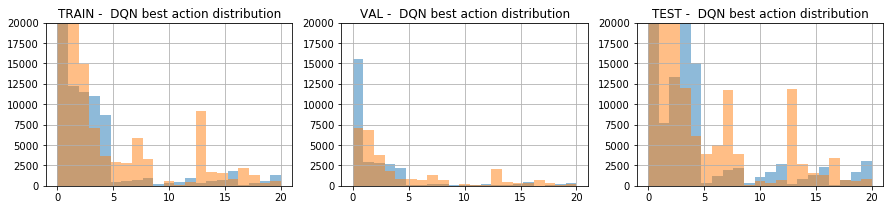

interim model:165000


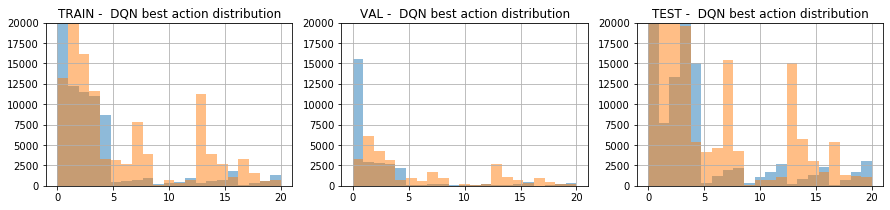

interim model:170000


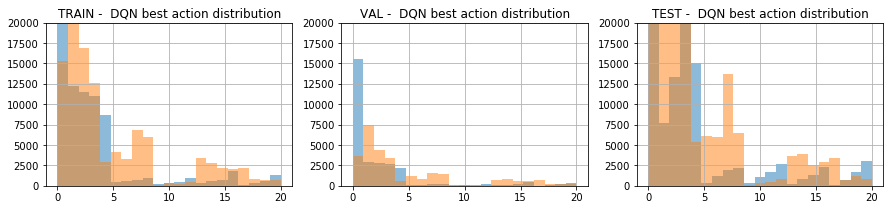

interim model:175000


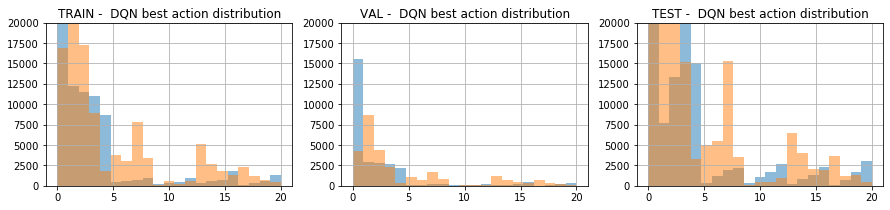

interim model:180000


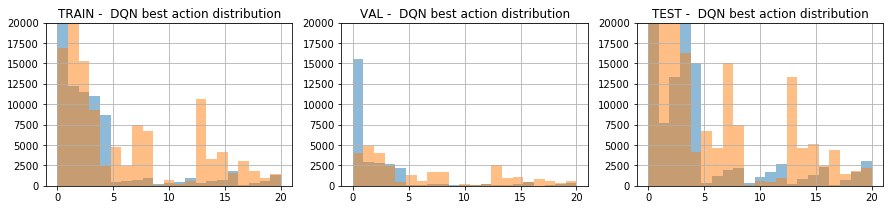

interim model:185000


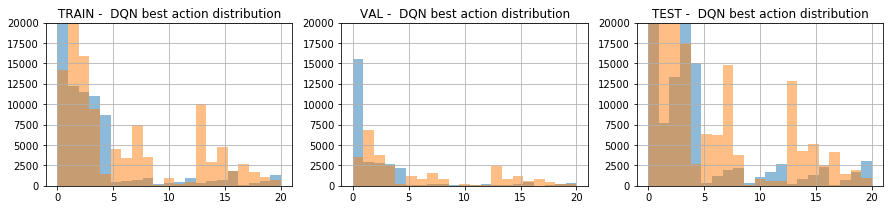

interim model:190000


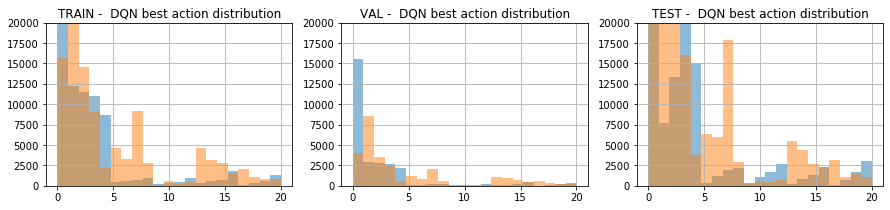

interim model:195000


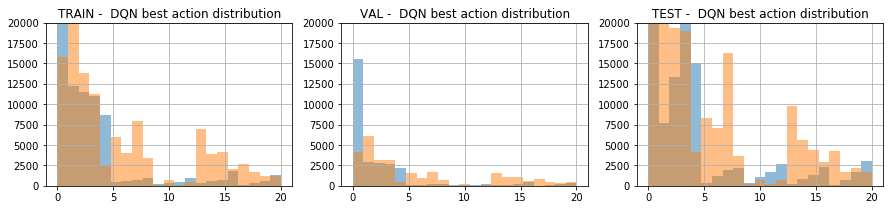

interim model:200000


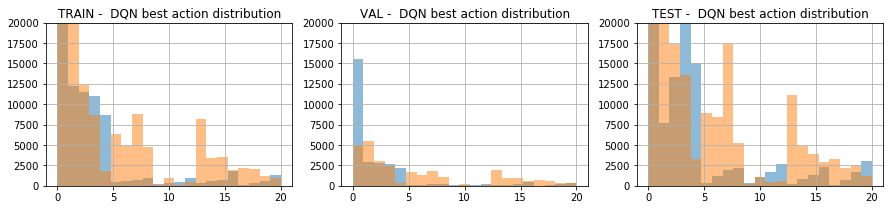

interim model:205000


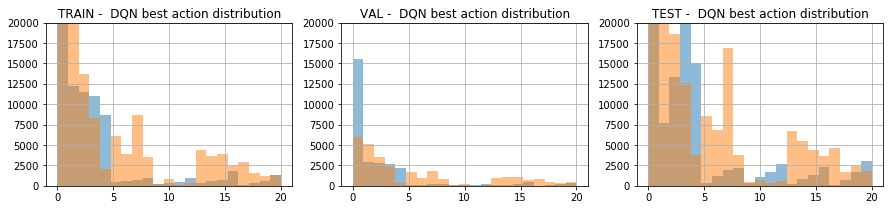

interim model:210000


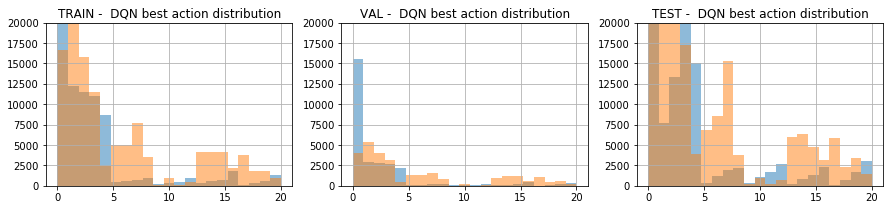

interim model:215000


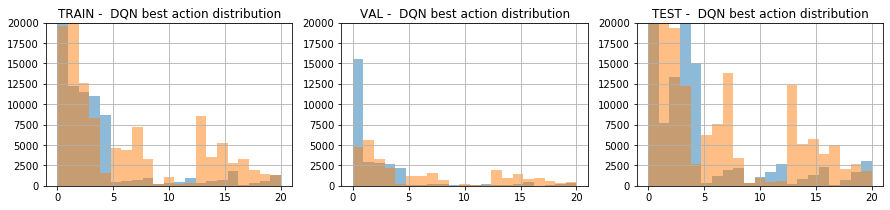

interim model:220000


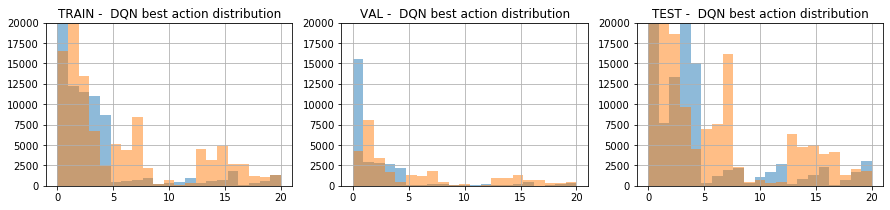

interim model:225000


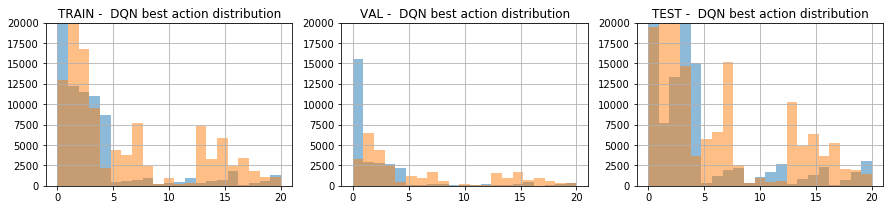

interim model:230000


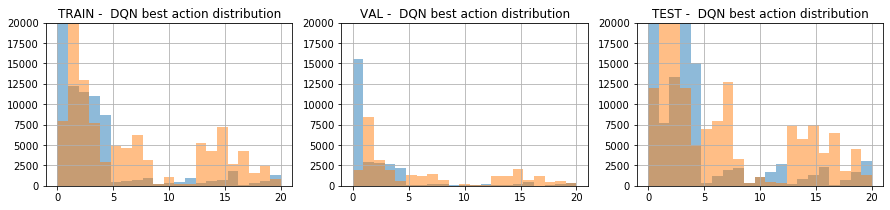

interim model:235000


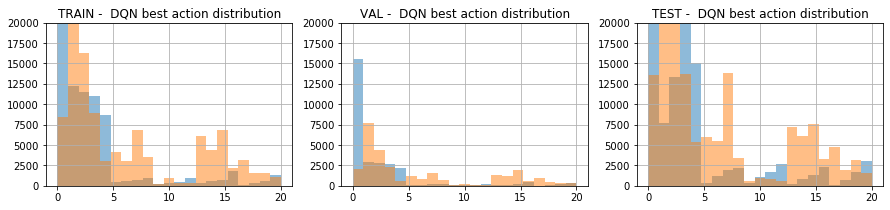

interim model:240000


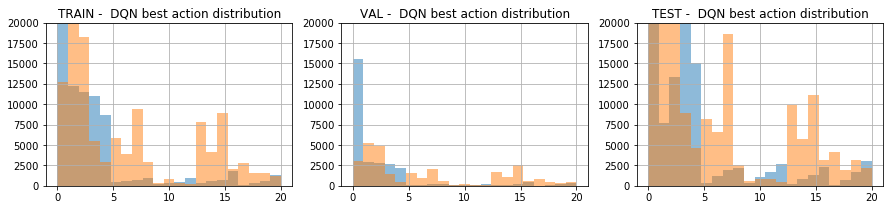

interim model:245000


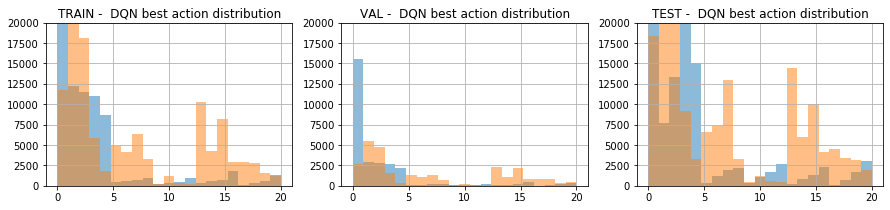

interim model:250000


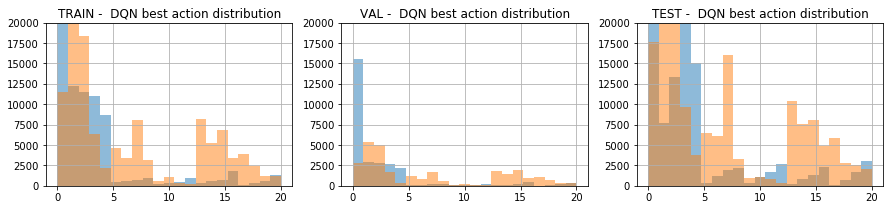

interim model:255000


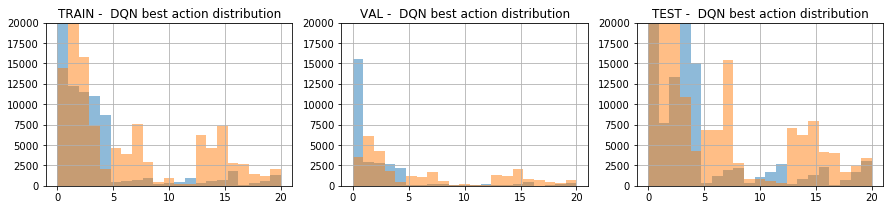

interim model:260000


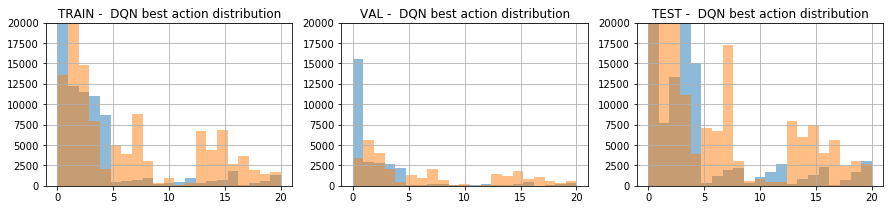

interim model:265000


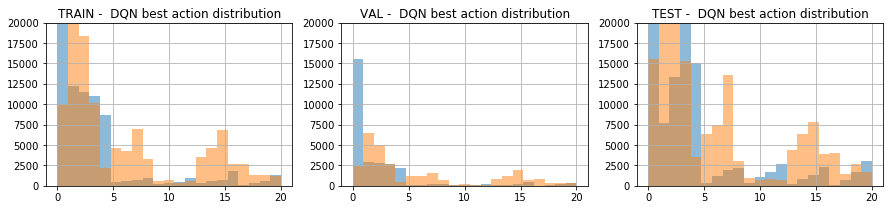

interim model:270000


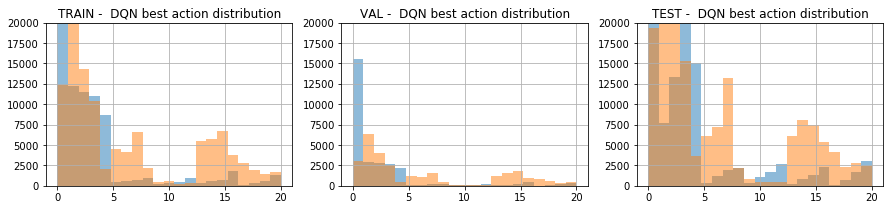

interim model:275000


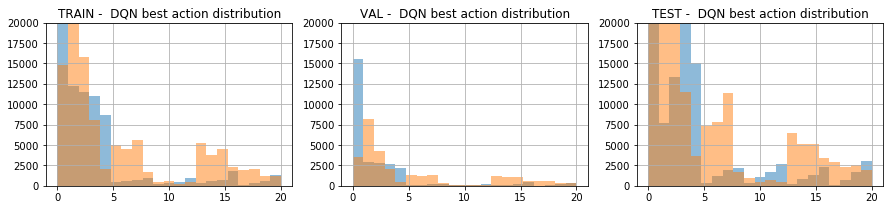

interim model:280000


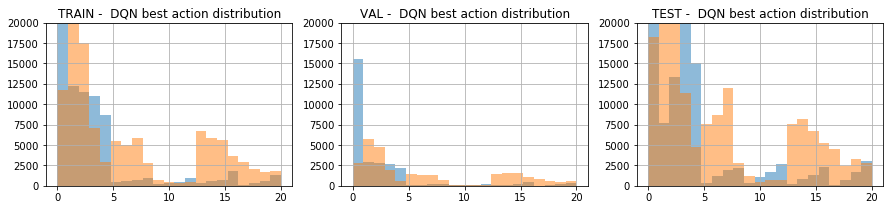

interim model:285000


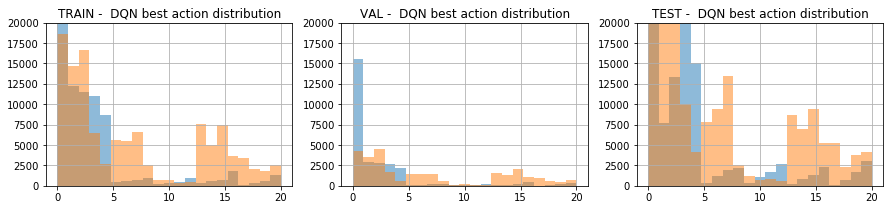

interim model:290000


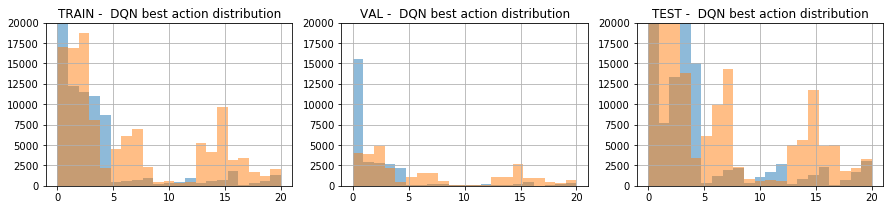

interim model:295000


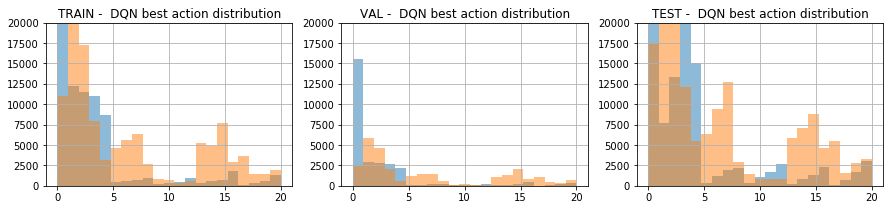

interim model:300000


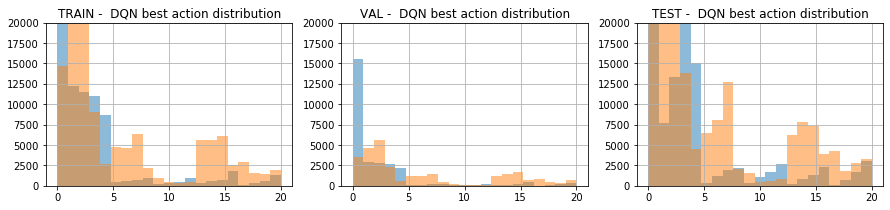

interim model:305000


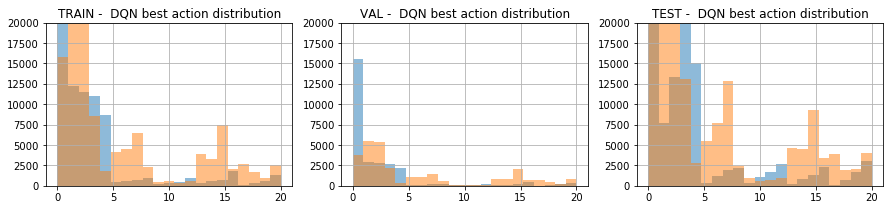

interim model:310000


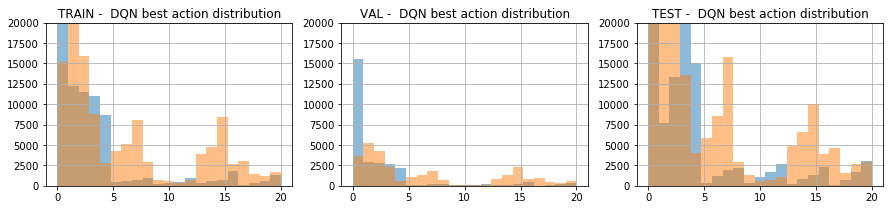

interim model:315000


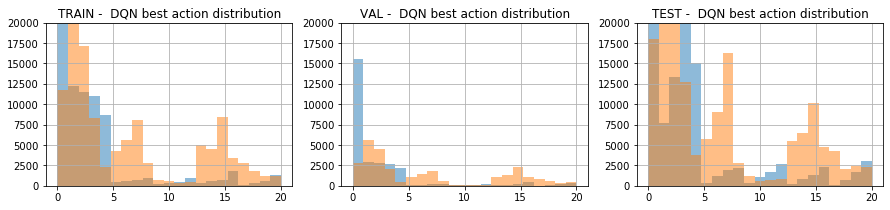

interim model:320000


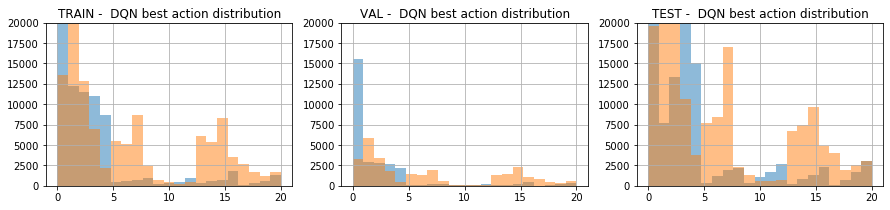

interim model:325000


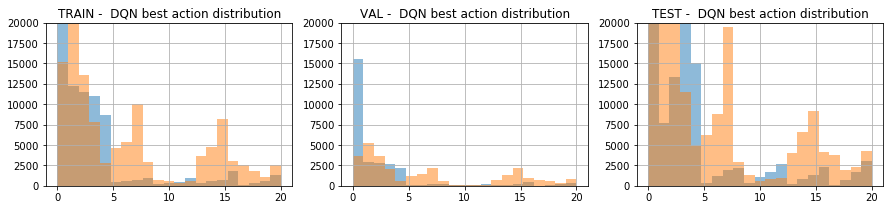

interim model:330000


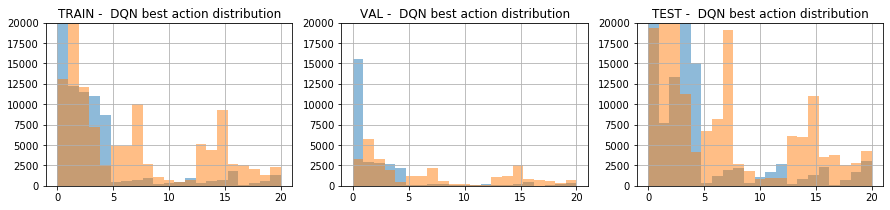

interim model:335000


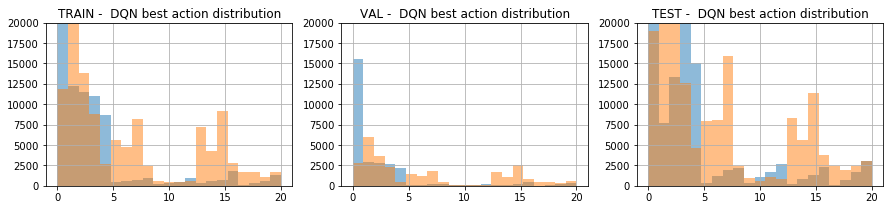

interim model:340000


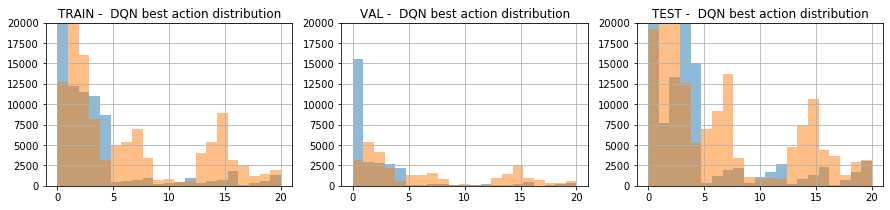

interim model:345000


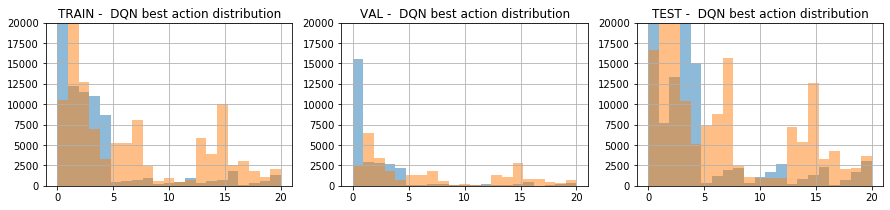

interim model:350000


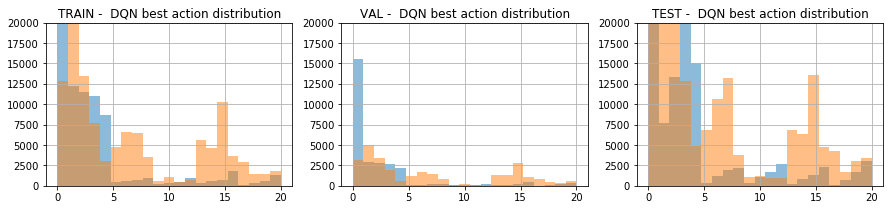

done


In [8]:
print("Experiment \""+ str(exp_name) + "\" loaded with grid: " + str(exp_grid_run))
interim_model_list = np.arange(config['interim_step'], config['num_epochs']+config['interim_step'], config['interim_step'])
count=0
for interim_model in interim_model_list:
    try:
        count+=1
        exp_model = exp_name + '_' + str(exp_grid_run) + '_interim_'+ str(interim_model) +'_iteration_model.chk'
        selected_model = os.path.join(exp_resultsdir, exp_model)
        ############################################
        # Load model    
        if use_gpu:
            model = model.cuda()
            model.load_state_dict(torch.load(selected_model))
        else:
            model.load_state_dict(torch.load(selected_model, map_location=lambda storage, loc: storage))

        ############################################
        ### visual inspection of action and action probability distribution in the dataset
        print("interim model:" +str(interim_model))
        # Create multiplot
        plt.figure(figsize=(15, 3))

        # best action distribution
        outputs, best_actions, best_action_probabilities, outputs_prob, state_Q_values, best_policy_values = evaluate_model(model, data_dict, 'train', use_gpu) 
        plt.subplot(131)
        pd.Series(data_dict['train']['action']).hist(bins=21,alpha=0.5)
        pd.Series(best_actions).hist(bins=21,alpha=0.5)
        plt.ylim(0,20000)
        plt.title("TRAIN -  DQN best action distribution")

        # best action distribution
        outputs, best_actions, best_action_probabilities, outputs_prob, state_Q_values, best_policy_values = evaluate_model(model, data_dict, 'val', use_gpu) 
        plt.subplot(132)
        pd.Series(data_dict['val']['action']).hist(bins=21,alpha=0.5)
        pd.Series(best_actions).hist(bins=21,alpha=0.5)
        plt.ylim(0,20000)
        plt.title("VAL -  DQN best action distribution")

        # best action distribution
        outputs, best_actions, best_action_probabilities, outputs_prob, state_Q_values, best_policy_values = evaluate_model(model, data_dict, 'test', use_gpu) 
        plt.subplot(133)
        pd.Series(data_dict['test']['action']).hist(bins=21,alpha=0.5)
        pd.Series(best_actions).hist(bins=21,alpha=0.5)
        plt.ylim(0,20000)
        plt.title("TEST -  DQN best action distribution")

        # visual inspection
        plt.show()
        
    ### Catch "Still training error"   
    except:
        print("End of interim model list")
        break
print("done")

In [9]:
############################################
interim_model = False
interim = 220000

###################
# OPTIONAL: Load INTERIM model, else use final model as defined above
if interim_model:
    exp_model = exp_dir + '/models/' + exp_name + '_' + str(exp_grid_run) + '/' + exp_name + '_' + str(exp_grid_run) + '_interim_' + str(interim) + '_iteration_model.chk'
else:
    exp_model = exp_dir + '/models/' + exp_name + '_' + str(exp_grid_run) + '_model.chk'  
###################
### LOAD MODEL file and MODEL CONFIG FILE
selected_model = os.path.join(exp_dir, exp_model)

###################
# Load model    
if use_gpu:
    model = model.cuda()
    model.load_state_dict(torch.load(selected_model))
else:
    model.load_state_dict(torch.load(selected_model, map_location=lambda storage, loc: storage))
print("loaded model: " + exp_model)
print("Finished at: " + str(datetime.now()) + "\n")  

loaded model: C:/Users/gmpxe/Downloads/MIMIC_data_allbins.csv/Luca_experiment//models/lucspace_1_model.chk
Finished at: 2022-06-10 23:11:47.480575



loaded model: lucspace_1_interim_350000_iteration_model.chk
(115218, 21)
train
Phy WDR: 1.9362
DQN WDR: 8.551
Phy WIS: 1.9021
DQN WIS: 2.5015



(28818, 21)
val
Phy WDR: 2.3504
DQN WDR: 9.8053
Phy WIS: 1.8141
DQN WIS: 2.4882



(176598, 21)
test
Phy WDR: 4.6861
DQN WDR: 9.5816
Phy WIS: 1.832
DQN WIS: 2.4714





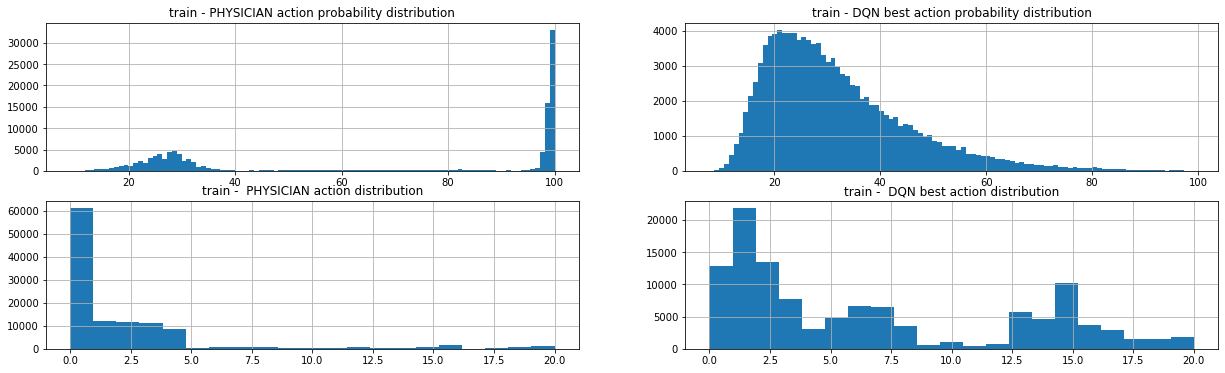

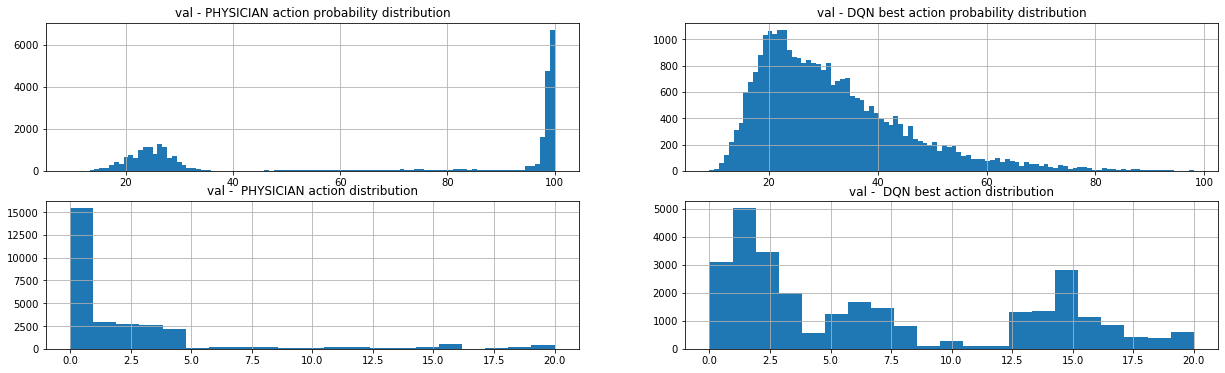

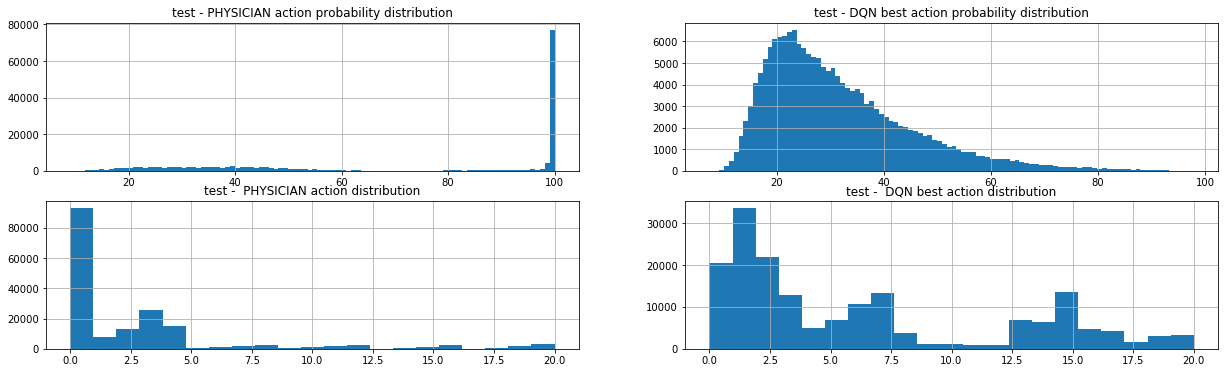

In [98]:
print("loaded model: " + exp_model)
eval_types = ['train', 'val', 'test']
for eval_type in eval_types:
    # gamma
    gamma = config['gamma']
        
    # action probabilities of physician's action used for intermediate evaluateion
    pi_behavior = pd.read_pickle(os.path.join(data_dir, 'KNN_pi_behavior_' + eval_type + 'data.pkl'))
    
    # eval dataset MDP Q function
    Q = pd.read_pickle(os.path.join(data_dir, 'FQI_QValues_' + eval_type + 'data.pkl'))

    ############################################
    # Model evaluation
    outputs, best_actions, best_action_probabilities, outputs_prob, state_Q_values, best_policy_values = evaluate_model(model, data_dict, eval_type, use_gpu)   
    print(outputs.shape)

    ############################################
    # keep copy of Q VALUES
    results_df = pd.DataFrame.from_records(outputs)
    results_df = np.around(results_df,3)
    results_df.columns =  ['Q' + str(i) for i in np.unique(data_dict[eval_type]['action'])]

    # Add best action 
    results_df['best_action'] = best_actions

    # Add action Q values
    results_df['phy_action_Qvalue'] = state_Q_values
    results_df['best_action_Qvalue'] = best_policy_values

    # Add state id
    results_df['state_id'] = data_dict[eval_type]['state_id']
    
    # Save
    results_df.to_csv(os.path.join(exp_resultsdir, 'DQN_Qvalues_' + eval_type + 'data.csv'), index=False)
    
    ############################################
    # keep copy of Q VALUES PROBABILITES
    action_prob_df = pd.DataFrame.from_records(outputs_prob)
    action_prob_df = np.around(action_prob_df,3)
    action_prob_df.columns =  ['A' + str(i) for i in np.unique(data_dict[eval_type]['action'])]

    # Add best action 
    action_prob_df['best_action'] = best_actions

    # Add best action probabilites
    action_prob_df['best_action_probability'] = best_action_probabilities

    # Add state id
    action_prob_df['state_id'] = data_dict[eval_type]['state_id']
    
    # Save
    action_prob_df.to_csv(os.path.join(exp_resultsdir, 'DQN_action_prob_df_' + eval_type + 'data.csv'), index=False)
    
    ############################################
    ### visual inspection of action and action probability distribution in the dataset
    # Create multiplot
    plt.figure(figsize=(21, 6))
    
    plt.subplot(221)
    phy_action_probabilities = pi_behavior.max(axis=1)
    pd.Series(phy_action_probabilities*100).hist(bins=100)
    plt.title(str(eval_type) + " - PHYSICIAN action probability distribution")    
    
    plt.subplot(222)
    best_action_probabilities = outputs_prob.max(axis=1)
    pd.Series(best_action_probabilities*100).hist(bins=100)
    plt.title(str(eval_type) + " - DQN best action probability distribution")

    plt.subplot(223)
    pd.Series(data_dict[eval_type]['action']).hist(bins=21)
    plt.title(str(eval_type) + " -  PHYSICIAN action distribution")

    # best action distribution
    plt.subplot(224)
    pd.Series(best_actions).hist(bins=21)
    plt.title(str(eval_type) + " -  DQN best action distribution")

    # visual inspection
    #plt.savefig(os.path.join(exp_figuresdir, 'Eval_DQN_histrogram_multiplot_'+ str(eval_type) +'.tiff'),dpi=200,transparent=True)
    
    #############################################
    # create an output dataframe with for the Q values and action probability
    pi_evaluation = np.around(pd.DataFrame.from_records(outputs_prob),3)
    #DQN based Q model 
    Q_DQN = results_df.iloc[:,0:21]
   
    # Perform WOPE
    Phys_WDR, Phys_wis = eval_WDR(data_dict, eval_type, gamma, pi_behavior, pi_behavior, Q)
    model_WDR, model_wis = eval_WDR(data_dict, eval_type, gamma, pi_evaluation, pi_behavior, Q_DQN) # luca is using wron mDP here 
    


    # Results
    print( str(eval_type) + "\nPhy WDR: " + str(round(Phys_WDR, 4)) 
                          + "\nDQN WDR: " + str(round(model_WDR, 4)) 
                          + "\nPhy WIS: " + str(round(Phys_wis, 4)) 
                          + "\nDQN WIS: " + str(round(model_wis, 4)))
    print('\n\n')

In [11]:
reqcols = ['icustay_id', 'interval_start_time', 'interval_end_time', 'reward', 'hospital_expire_flag', 'phy_action_Qvalue', 'best_action_Qvalue', 'best_action']

In [74]:
results_df[reqcols].to_csv('results/mortality_test_data.csv')

In [50]:
val_set = pd.read_csv('../commondata/val_data_scaled_imputed.csv')
val_set1 = val_set[data_dict['featurenames'].tolist()+['row_id', 'row_id_next' , 'Reward' ,'discrete_action']]
import numpy as np
indices = np.random.choice(val_set1.shape[0], replace=False, size=500)

In [51]:
def get_fence_post1(df):
    df['row_id']
    df['row_id_next']
    fence_post_array = np.equal(np.array(df['row_id']),np.array(df['row_id_next']))
    index_of_end_of_trajectory = np.append([-1], np.argwhere(fence_post_array==True).flatten(order='C')) # add index 0, the start of the first trajectory
    index_of_beginning_of_new_trajectory = index_of_end_of_trajectory
    index_of_beginning_of_new_trajectory[:] = [x + 1 for x in index_of_end_of_trajectory]
    return index_of_beginning_of_new_trajectory[:-1] 

In [69]:
def get_my_data(df, indices, Q, Q_DQN, pi_behavior, pi_evaluation):
    fence_posts = get_fence_post1(df.iloc[indices])
    actions_sequence = df.iloc[indices]['discrete_action']
    rewards_sequence = df.iloc[indices]['Reward']
    pi_e = pi_evaluation.iloc[indices]
    pi_b = pi_behavior.iloc[indices]
    #model_WDR, model_wis = WDR(actions_sequence, rewards_sequence, fence_posts, gamma, pi_e, pi_b, Q_DQN.iloc[indices].max(axis=1), Q_DQN.iloc[indices])
    return fence_posts, actions_sequence, rewards_sequence, pi_e, pi_b



In [58]:
Q.iloc[indices].max(axis=1)

state_id
10867.0     8.485
21237.0    11.540
17374.0     2.749
16281.0     3.894
12203.0     6.821
            ...  
14028.0     6.229
15409.0     2.749
24579.0     2.749
1956.0      5.373
9306.0      2.749
Length: 500, dtype: float64

In [95]:
fence_posts, actions_sequence, rewards_sequence, pi_e, pi_b = get_my_data(val_set1, indices, Q, Q_DQN, pi_behavior, pi_evaluation)

In [96]:
WDR(actions_sequence, rewards_sequence, fence_posts, 0.9,
 pi_evaluation.iloc[indices].reset_index(drop=True), 
 pi_behavior.iloc[indices].reset_index(drop=True),
 Q.iloc[indices].max(axis=1).reset_index(drop=True),  Q.iloc[indices].reset_index(drop=True))

(1.4653390679522884, 2.5015769653462443)

In [97]:
indices = range(0,3600)